In [1]:
!pip install kaggle
from google.colab import files
files.upload()


!mkdir -p ~/.kaggle 

!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

100% 2.54G/2.54G [00:41<00:00, 87.1MB/s]
100% 2.54G/2.54G [00:41<00:00, 65.9MB/s]


In [3]:
import zipfile
import os
def un_zip(file_name):
    """unzip zip file"""
    zip_file = zipfile.ZipFile(file_name)
    if os.path.isdir(file_name + "_files"):
        pass
    else:
        os.mkdir(file_name + "_files")
    for names in zip_file.namelist():
        zip_file.extract(names,file_name + "_files/")
    zip_file.close()

un_zip('/content/en-fr-translation-dataset.zip')


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [5]:
df = pd.read_csv("/content/en-fr-translation-dataset.zip_files/en-fr.csv", nrows=8000000)

In [6]:
# import packages
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# device type "cuda" or "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # word → index (word2index)
        self.word2count = {} # index → word (index2word)
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # count SOS and EOS
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    '''
    For each character, there are two normal forms: 
    normal form C and normal form D. 
    Normal form D (NFD) is also known as canonical decomposition, and translates each character into its decomposed form. 
    Normal form C (NFC) first applies a canonical decomposition, then composes pre-combined characters again.
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
MAX_LENGTH = 30 # max 10 words including ending punctuation
hidden_size = 256

In [9]:
def readLang(lang1, lang2, reverse=False):
    print("Reading lines...")
    # split into two lines
    lines = df.values.tolist()
    # select everyline into pairs and normalize
    pairs = [
        [normalizeString(str(s)) for s in l] for l in lines
    ]
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

# filtering to sentences that translate to the form “I am” or “He is” etc.
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLang(lang1, lang2, reverse)
    print(f"Read sentence pairs: {len(pairs)}")
    pairs = filterPairs(pairs)
    print(f"Trimmed to sentence pairs: {len(pairs)}")
    print(f"COUNTING WORDS...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted Words...")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(df.columns.tolist()[0], df.columns.tolist()[1], True)
print(random.choice(pairs)) # random choice of pairs

Reading lines...
Read sentence pairs: 8000000
Trimmed to sentence pairs: 16663
COUNTING WORDS...
Counted Words...
fr 18781
en 14262
['on s interesse aussi aux effets d autres interventions en sante publique comme la promotion de l hygiene l eau potable et les installations sanitaires .', 'they are also looking at the effects of other health interventions such as hygiene promotion adequate drinking water and sanitation .']


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedding = self.embedding(input).view(1, 1, -1)
        output = embedding
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    """docstring for DecoderRNN"""
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print("input_tensor", input_tensor.shape)
    #print("target_tensor", target_tensor.shape)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        #print("input_length", input_length)
        #print("input_tensor[ei].shape", input_tensor[ei].shape)
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden
        )
        #print("encoder_hidden.shape", encoder_hidden.shape)
        encoder_outputs[ei] = encoder_output[0, 0]
        #print("encoder_outputs[ei].shape", encoder_outputs[ei].shape)
        #print("=============")
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [14]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(s))

In [15]:
def showplot(points):
    plt.figure()
    # fig, ax = plt.subplots()
    # loc = ticker.MultipleLocator(base=0.2)
    # ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [16]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):  # epochs
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(
            input_tensor, target_tensor, 
            encoder, decoder, 
            encoder_optimizer, decoder_optimizer, 
            criterion
        )

        print_loss_total += loss  
        plot_loss_total = loss  

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # if iter % plot_every == 0:
        #     print("plt")
        #     plot_loss_avg = plot_loss_total / plot_every
        #     plot_losses.append(plot_loss_avg)
        #     plot_loss_total = 0
        #     showplot(plot_losses)
        
        plot_losses.append(plot_loss_total)
    return plot_losses

In [17]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 41s (- 1m 41s) (5000 6%) 4.7132
3m 19s (- 3m 19s) (10000 13%) 4.5419
5m 2s (- 5m 2s) (15000 20%) 4.4949
6m 44s (- 6m 44s) (20000 26%) 4.4027
8m 27s (- 8m 27s) (25000 33%) 4.2942
10m 10s (- 10m 10s) (30000 40%) 4.2048
11m 53s (- 11m 53s) (35000 46%) 4.1309
13m 35s (- 13m 35s) (40000 53%) 4.0061
15m 19s (- 15m 19s) (45000 60%) 3.9728
17m 3s (- 17m 3s) (50000 66%) 3.9240
18m 46s (- 18m 46s) (55000 73%) 3.8577
20m 30s (- 20m 30s) (60000 80%) 3.8025
22m 14s (- 22m 14s) (65000 86%) 3.7545
23m 57s (- 23m 57s) (70000 93%) 3.6686
25m 41s (- 25m 41s) (75000 100%) 3.6186


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


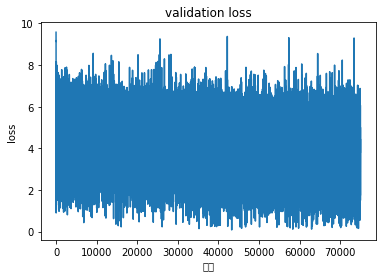

In [18]:


plt.plot(plot_losses)
plt.xlabel('次數')
plt.ylabel('loss')

plt.title('validation loss')
plt.show()

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [20]:
from nltk.translate.bleu_score import sentence_bleu
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print("BLEU socre:", sentence_bleu(pair[1].split(), output_sentence.split() ))
        print('')
evaluateRandomly(encoder1, decoder1)

> il fait actuellement partie du conseil d administration de l association mondiale pour le droit medical dont il est aussi un des vice presidents .
= he is now a member of the board of governors of the world association for medical law and an association vice president .
< he is currently a member of the board of of of of <EOS>
BLEU socre: 9.594503055152632e-232

> l intimidation a des repercussions sur tous les jeunes concernes tant l intimidateur que la victime et les temoins .
= they are also more likely to engage in school delinquency and substance use .
< they are also involved in identifying and that the national of environmental groups . <EOS>
BLEU socre: 9.257324954728539e-232

> elles visent aussi a guider les professionnels dans l elaboration de programmes nouveaux et efficaces qui renforcent les comportements favorables a la sante sexuelle .
= they are also meant to guide professionals in the development of new and effective programs that reinforce behaviours that support s

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [21]:
# Test
# def translateText(input_text):
#     output_words = evaluate(
#         encoder1, decoder1, normalizeString(input_text)
#     )
#     output_sentence = ' '.join(output_words)
#     return f"Output Sentence: {output_sentence}"

# translateText(input_text=input("Type sentence: "))